In [1]:
# importazione librerie necessarie
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing import image

In [2]:
# caricamento dataset in memoria
(x_train, _), (x_test, y_test) = mnist.load_data()

# normalizzazione dataset
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

y_x_train = x_train[:]

In [3]:
# creazione di un dataset di immagini
# disturbate (il 65% dei pixel sono disturbo)
noise_factor = 0.65
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

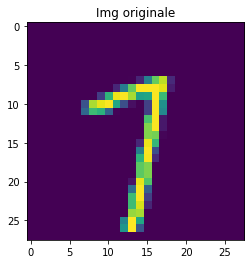

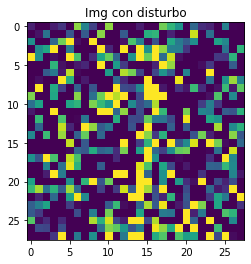

In [4]:
plt.title('Img originale')
plt.imshow(x_train[42])
plt.show()

plt.title('Img con disturbo')
plt.imshow(x_train_noisy[42])
plt.show()

In [5]:
# modello dell'autoencoder convolutivo
input_img = Input(shape=(28, 28, 1))

x = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoder = BatchNormalization()(x)

decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
x = UpSampling2D((2, 2))(decoder)
x = BatchNormalization()(x)


x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)


decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

optimizer = Nadam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 48)        480       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 48)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 48)        192       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        27712     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256   

In [6]:
# addestramento del modello
history = autoencoder.fit(x_train_noisy, x_train, epochs=100, batch_size=1024, verbose=2)

Epoch 1/100
59/59 - 7s - loss: 0.4446
Epoch 2/100
59/59 - 2s - loss: 0.2214
Epoch 3/100
59/59 - 2s - loss: 0.1504
Epoch 4/100
59/59 - 2s - loss: 0.1372
Epoch 5/100
59/59 - 2s - loss: 0.1299
Epoch 6/100
59/59 - 2s - loss: 0.1269
Epoch 7/100
59/59 - 2s - loss: 0.1245
Epoch 8/100
59/59 - 3s - loss: 0.1238
Epoch 9/100
59/59 - 2s - loss: 0.1218
Epoch 10/100
59/59 - 2s - loss: 0.1206
Epoch 11/100
59/59 - 3s - loss: 0.1203
Epoch 12/100
59/59 - 2s - loss: 0.1192
Epoch 13/100
59/59 - 3s - loss: 0.1184
Epoch 14/100
59/59 - 2s - loss: 0.1181
Epoch 15/100
59/59 - 2s - loss: 0.1174
Epoch 16/100
59/59 - 2s - loss: 0.1168
Epoch 17/100
59/59 - 2s - loss: 0.1163
Epoch 18/100
59/59 - 3s - loss: 0.1159
Epoch 19/100
59/59 - 2s - loss: 0.1156
Epoch 20/100
59/59 - 3s - loss: 0.1150
Epoch 21/100
59/59 - 3s - loss: 0.1149
Epoch 22/100
59/59 - 3s - loss: 0.1145
Epoch 23/100
59/59 - 3s - loss: 0.1142
Epoch 24/100
59/59 - 3s - loss: 0.1138
Epoch 25/100
59/59 - 2s - loss: 0.1136
Epoch 26/100
59/59 - 3s - loss: 0.

Text(0, 0.5, 'Loss')

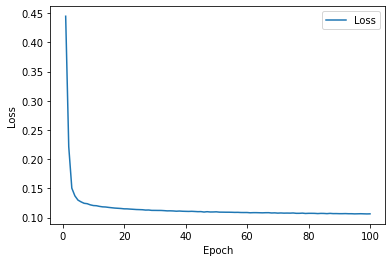

In [7]:
# grafico dell'andamento dell'addestramento
_ , ax = plt.subplots()
ax.plot([None] + history.history['loss'])
ax.legend(['Loss'], loc=0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

In [8]:
for l in autoencoder.layers:
    print(l)
print(len(autoencoder.layers))

14


In [9]:
# costruzione dataset di immagini codificate
# utilizzando le immagini del set di validazione
encoder_model = Sequential()
for layer in autoencoder.layers[0:7]:
    encoder_model.add(layer)
encoded_imgs = encoder_model.predict(x_test)

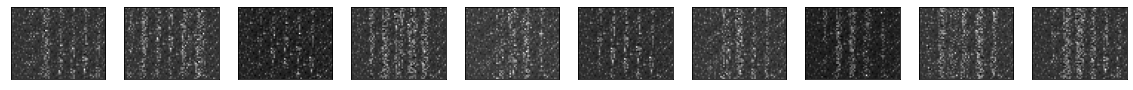

In [10]:
# possiamo dare uno sguardo alle rappresentazione delle immagini codificate

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(64, 49).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

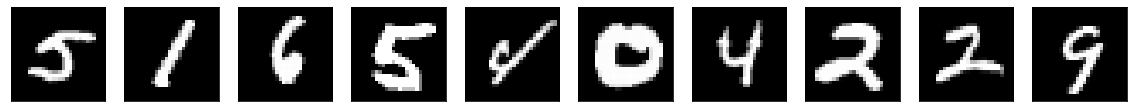

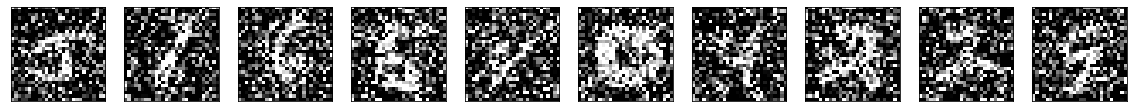

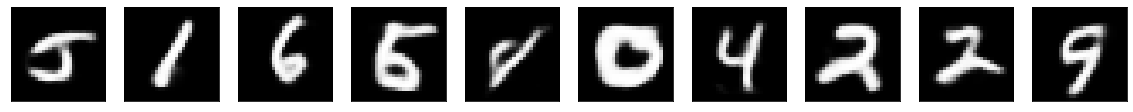

In [11]:
# visualizzazione delle immagini di test
# passandole per il generatore di disturbo
# e quindi per l'autoencoder
n = 10
idxs = []
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    idx = np.random.rand(1) * 10000
    idxs.append(int(idx))
    plt.imshow(x_test[idxs[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[idxs[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    new_img = autoencoder.predict(x_test_noisy[idxs[i]].reshape(1, 28, 28, 1))
    plt.imshow(new_img.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [12]:
# aumento del disturbo nelle immagini
# di test da dare in input
noise_factor = 0.80
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

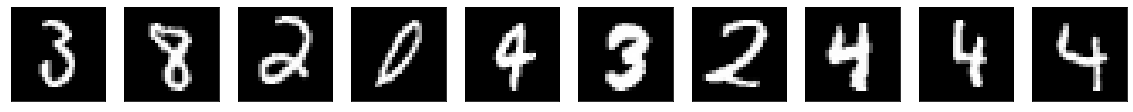

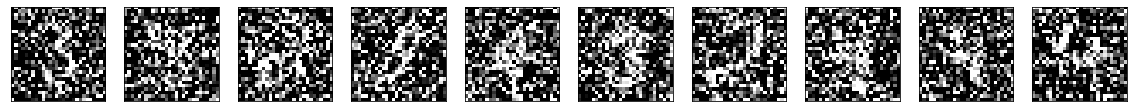

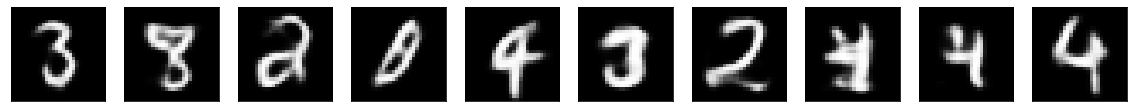

In [13]:
# visualizzazione delle immagini di test
# passandole per il generatore di disturbo
# e quindi per l'autoencode
n = 10
idxs = []
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    idx = np.random.rand(1) * 10000
    idxs.append(int(idx))
    plt.imshow(x_test[idxs[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[idxs[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    new_img = autoencoder.predict(x_test_noisy[idxs[i]].reshape(1, 28, 28, 1))
    plt.imshow(new_img.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

(144, 428, 548, 3) (72, 428, 548, 3)


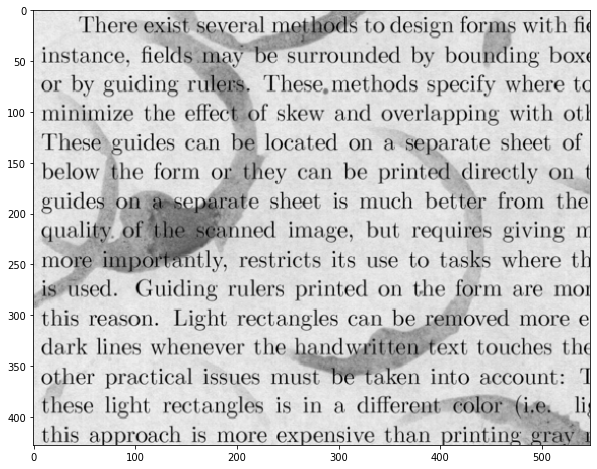

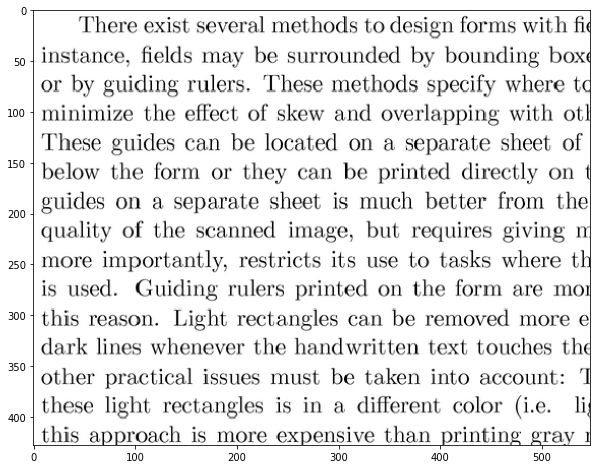

In [14]:
# caricamento dataset di testi "rovinati" e originali
TRAIN_IMAGES = glob.glob('data/ocr/train/*.png')
CLEAN_IMAGES = glob.glob('data/ocr/train_cleaned/*.png')
TEST_IMAGES = glob.glob('data/ocr/test/*.png')

def load_image(path):
    image_list = np.zeros((len(path), 428, 548, 3))
    for i, fig in enumerate(path):
        img = image.load_img(fig, target_size=(428, 548), grayscale=False)
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    return image_list

x_train = load_image(TRAIN_IMAGES)
y_train = load_image(CLEAN_IMAGES)
x_test = load_image(TEST_IMAGES)

print(x_train.shape, x_test.shape)

plt.figure(figsize=(20,8))
plt.imshow(x_train[42])

plt.figure(figsize=(20,8))
plt.imshow(y_train[42])

In [16]:
# costruzione di un nuovo autoencoder convolutivo, con una struttura
# più complessa della precedente per svolgere meglio l'attuale
# compito di eliminazione dei "disturbi" dalle immagini
input_img = Input(shape=(428, 548, 3))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

optimizer = Nadam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 428, 548, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 428, 548, 64)      1792      
_________________________________________________________________
batch_normalization_10 (Batc (None, 428, 548, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 214, 274, 64)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 214, 274, 128)     73856     
_________________________________________________________________
batch_normalization_11 (Batc (None, 214, 274, 128)     512       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 107, 137, 128)     0   

In [17]:
# addestramento
history = autoencoder.fit(x_train, y_train, epochs=100, batch_size=3, verbose=2)

Epoch 1/100
48/48 - 7s - loss: 0.6236
Epoch 2/100
48/48 - 4s - loss: 0.3668
Epoch 3/100
48/48 - 4s - loss: 0.2085
Epoch 4/100
48/48 - 4s - loss: 0.1707
Epoch 5/100
48/48 - 4s - loss: 0.1572
Epoch 6/100
48/48 - 4s - loss: 0.1478
Epoch 7/100
48/48 - 4s - loss: 0.1614
Epoch 8/100
48/48 - 4s - loss: 0.1370
Epoch 9/100
48/48 - 4s - loss: 0.1330
Epoch 10/100
48/48 - 4s - loss: 0.1306
Epoch 11/100
48/48 - 4s - loss: 0.1265
Epoch 12/100
48/48 - 4s - loss: 0.1242
Epoch 13/100
48/48 - 4s - loss: 0.1225
Epoch 14/100
48/48 - 4s - loss: 0.1227
Epoch 15/100
48/48 - 4s - loss: 0.1180
Epoch 16/100
48/48 - 4s - loss: 0.1177
Epoch 17/100
48/48 - 4s - loss: 0.1157
Epoch 18/100
48/48 - 4s - loss: 0.1150
Epoch 19/100
48/48 - 4s - loss: 0.1141
Epoch 20/100
48/48 - 4s - loss: 0.1136
Epoch 21/100
48/48 - 4s - loss: 0.1122
Epoch 22/100
48/48 - 4s - loss: 0.1109
Epoch 23/100
48/48 - 4s - loss: 0.1096
Epoch 24/100
48/48 - 4s - loss: 0.3327
Epoch 25/100
48/48 - 4s - loss: 0.2579
Epoch 26/100
48/48 - 4s - loss: 0.

Text(0, 0.5, 'Loss')

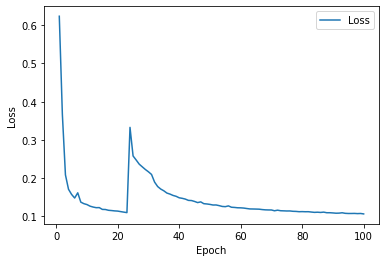

In [18]:
# tracciamento grafico relativo al processo di apprendimento
_ , ax = plt.subplots()
ax.plot([None] + history.history['loss'])
ax.legend(['Loss'], loc=0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

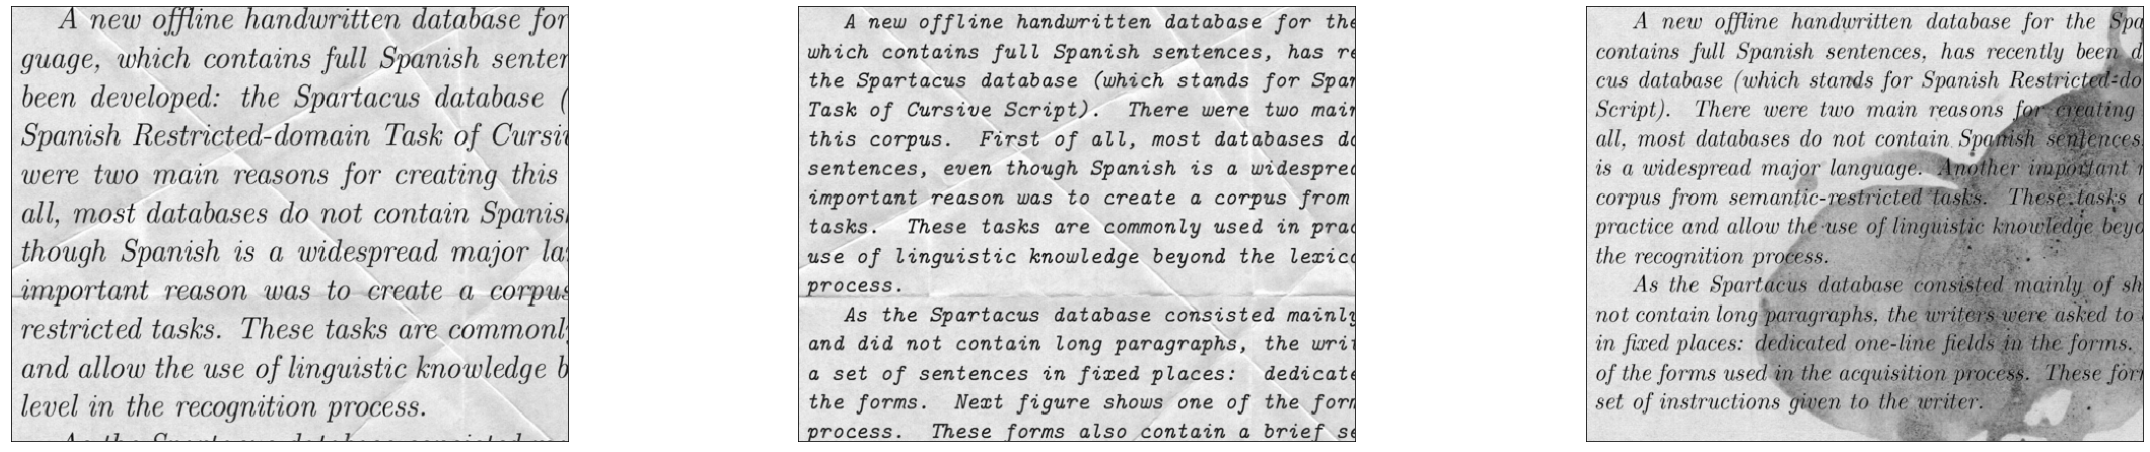

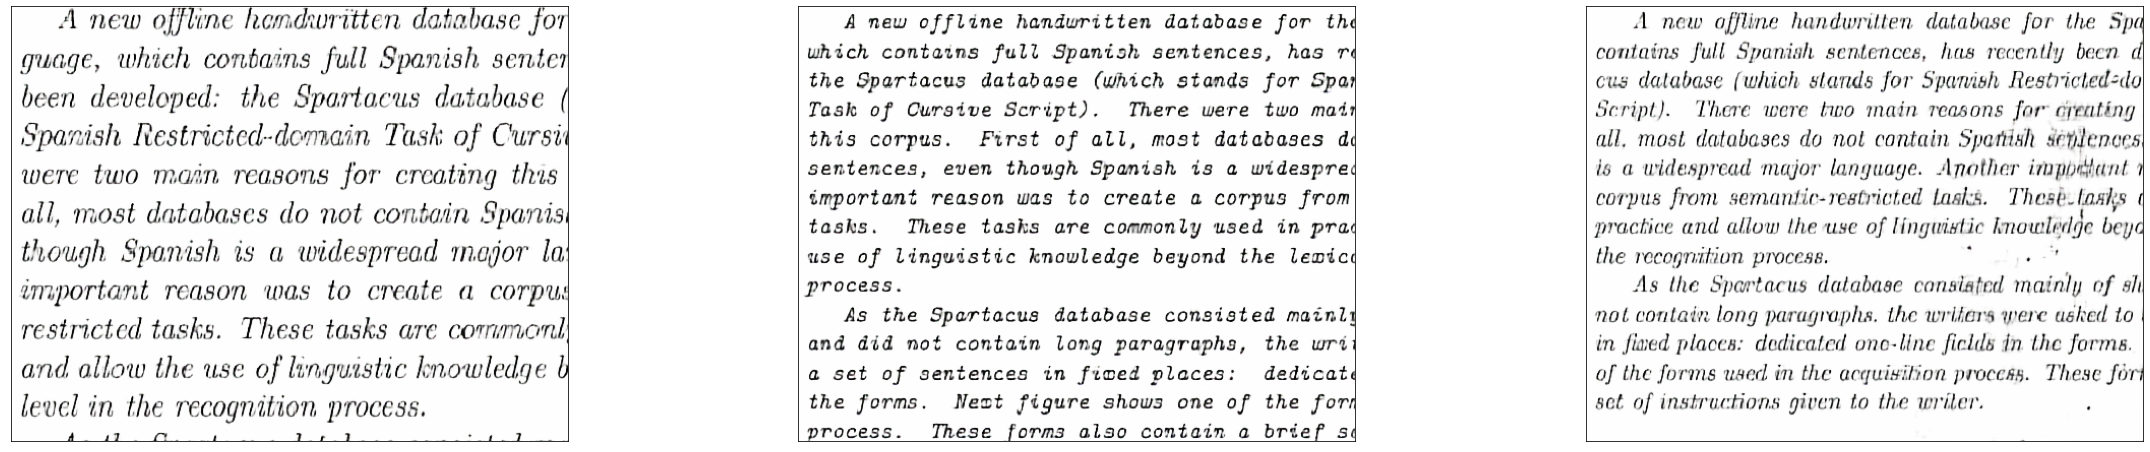

In [19]:
# test del modello su nuove immagini danneggiate
n = 3
idxs = []
plt.figure(figsize=(40, 8))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    idx = np.random.rand(1) * len(x_test)
    idxs.append(int(idx))
    plt.imshow(x_test[idxs[i]].reshape(428, 548, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(40, 8))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    new_img = autoencoder.predict(x_test[idxs[i]].reshape(1, 428, 548, 3))
    plt.imshow(new_img.reshape(428, 548, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()